In [1]:
import numpy      as np
import pandas     as pd
from   pandas     import read_csv

import tensorflow as tf
from   tensorflow import keras

import matplotlib.pyplot as plt 

##### 
### Functions

In [2]:
# Time-Series Generator
def generate_time_series( bSize, nSteps ):  
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, bSize, 1)
    time = np.linspace(0, 1, nSteps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))     #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
    series += 0.1 * (np.random.rand(bSize, nSteps) - 0.5)             # + noise
    return series[..., np.newaxis].astype(np.float32)

# last_time_step_mse
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

##### 
### Forecasting 1 Time Step Ahead

In [ ]:
bSize  = 10000   # batch_size
nSteps = 50      #  n_steps
series = generate_time_series( bSize, nSteps+1 )  # (10000, 51, 1)
 
a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

X_train, y_train  =  series[  :a, :nSteps ],  series[  :a, -1 ]
X_valid, y_valid  =  series[ a:b, :nSteps ],  series[ a:b, -1 ]
X_test , y_test   =  series[ b: , :nSteps ],  series[ b: , -1 ]

In [ ]:
# Baseline Metrics   # mse=0.0200    
y_pred = X_test[ :, -1 ]
MSE = np.mean( keras.losses.mean_squared_error( y_test, y_pred ) )  
print('MSE =',np.round(MSE,4))

In [ ]:
# linear model   mse=.0035   bias=51 (fast)  
model = keras.models.Sequential([           
      keras.layers.Flatten( input_shape=[ nSteps, 1 ] )
    , keras.layers.Dense( 1 )
    ]) 
model.compile( loss      = "mse"
             , optimizer = "adam"  
             )
history = model.fit( X_train, y_train
                   , epochs          =  20
                   , validation_data = (X_valid, y_valid)
                   )
y_pred = model.predict( X_test )   
MSE = np.mean( keras.losses.mean_squared_error( y_test, y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

In [ ]:
# Deep RNNs      mse=.0030   (very slow)
model = keras.models.Sequential([
    
      keras.layers.SimpleRNN( 20 
                            , return_sequences = True    
                            , input_shape = [None, 1] )
    
    , keras.layers.SimpleRNN( 20 )  
    
    , keras.layers.Dense( 1 )
    
    ]) 

model.compile( loss      = "mse"
             , optimizer = "adam"  
             )
history = model.fit( X_train, y_train
                   , epochs          =  2
                   , validation_data = (X_valid, y_valid)
                   )

y_pred = model.predict( X_test ) 
MSE = np.mean( keras.losses.mean_squared_error( y_test, y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

##### 
### Forecasting N Time Steps Ahead

In [ ]:
bSize  = 10000   # batch_size
nSteps = 50      #  n_steps 

N = 10
n_neurons =  np.max( [20, 2*N] )

In [ ]:
# one-record only     MSE=.1500
series_1 = generate_time_series( 1, nSteps+N )   # (1, 60, 1)

X_new = series_1[ : , :nSteps ]                  # (1, 50, 1)
Y_new = series_1[ : , nSteps: ]                  # (1, 10, 1)

model = keras.models.Sequential([
    
      keras.layers.SimpleRNN( n_neurons 
                            , return_sequences = True    
                            , input_shape = [None, 1] )
    
    , keras.layers.SimpleRNN( n_neurons )  
    
    , keras.layers.Dense( 1 )
    
    ])

model.compile( loss      = "mse"
             , optimizer = "adam"  
             )
history = model.fit( X_train, y_train
                   , epochs          =  2
                   , validation_data = (X_valid, y_valid)
                   )

X = X_new   
for step_ahead in range(N):
    y_pred_one = model.predict( X[ : , step_ahead: ])[ : , np.newaxis , : ]
    X          = np.concatenate([ X , y_pred_one ], axis=1 )
    
Y_pred = X[:, nSteps:] 
MSE = np.mean( keras.losses.mean_squared_error( Y_new, Y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

In [ ]:
# a-batch-of-records  MSE=.0300 
series = generate_time_series( bSize, nSteps+N )
 
a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 

model = keras.models.Sequential([
    
      keras.layers.SimpleRNN( n_neurons 
                            , return_sequences = True
                            , input_shape = [None, 1] )
    
    , keras.layers.SimpleRNN( n_neurons
                            , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense(N) )
    
    ])

optimizer = keras.optimizers.Adam( learning_rate=0.01 )
model.compile( loss      = "mse"
             , optimizer =  optimizer
             , metrics   = [last_time_step_mse] )
history = model.fit( X_train, Y_train
                   , epochs          =  2
                   , validation_data = (X_valid, Y_valid)
                   )

Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nMSE =',np.round(MSE,4))

##### 
## Handling Long Sequences
2 Problems:
  - unstable gradients problem.
  - Short-Term Memory

In [ ]:
# Handling Unstable Gradients  ( 1 Method Only )

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size      = units
        self.output_size     = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

model = keras.models.Sequential([
    
      keras.layers.RNN( LNSimpleRNNCell( n_neurons )
                      , return_sequences = True
                      , input_shape = [None, 1] )
    
    , keras.layers.RNN( LNSimpleRNNCell( n_neurons )
                      , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense(N) )

    ])

In [ ]:
# Handling Short-Term Memory  ( 4 Methods )

# (1.1)   good   LSTM cells: long-term memory cells 
model = keras.models.Sequential([
      keras.layers.LSTM( 20
                       , return_sequences = True
                       , input_shape = [None, 1] )
      
    , keras.layers.LSTM( 20
                       , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense( N ) )
    
    ])



# (1.2) not-bad  LSTM cells: long-term memory cells 
model = keras.models.Sequential([
    
      keras.layers.RNN( keras.layers.LSTMCell( n_neurons )
                      , return_sequences = True
                      , input_shape = [None, 1] )
    
    , keras.layers.RNN( keras.layers.LSTMCell( n_neurons )
                      , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense( N ) )
    
    ]) 



# (2) Best   1D convolutional layers 
model = keras.models.Sequential([    
    
      keras.layers.Conv1D( filters     =  n_neurons   # default is 20
                         , kernel_size =  4
                         , strides     =  2
                         , padding     = "valid"
                         , input_shape = [None, 1] )  
      
    , keras.layers.GRU( n_neurons
                      , return_sequences = True )
    
    , keras.layers.GRU( n_neurons
                      , return_sequences = True )
    
    , keras.layers.TimeDistributed( keras.layers.Dense( N ) )
    
    ])

model.compile( loss      = "mse"
             , optimizer = "adam"
             , metrics   = [last_time_step_mse] )

history = model.fit( X_train, Y_train[:, 3::2]
                   , epochs = 20
                   , validation_data = ( X_valid, Y_valid[:, 3::2] ) )



# (3) Best   WaveNet 
model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))

model.compile( loss      = "mse"
             , optimizer = "adam"
             , metrics   = [last_time_step_mse]
             )

history = model.fit( X_train, Y_train
                   , epochs          =  20
                   , validation_data = (X_valid, Y_valid)
                   )

##### 
## Project 1:   Monthly Armed Robberies in Boston

In [3]:
Project_Name = 'Monthly_Robberies'

df = read_csv('Monthly-Robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df.head(5)

Month
1966-01-01    41
1966-02-01    39
1966-03-01    50
1966-04-01    40
1966-05-01    43
Name: Robberies, dtype: int64

In [4]:
S = df.values.astype('float32') 
S

array([ 41.,  39.,  50.,  40.,  43.,  38.,  44.,  35.,  39.,  35.,  29.,
        49.,  50.,  59.,  63.,  32.,  39.,  47.,  53.,  60.,  57.,  52.,
        70.,  90.,  74.,  62.,  55.,  84.,  94.,  70., 108., 139., 120.,
        97., 126., 149., 158., 124., 140., 109., 114.,  77., 120., 133.,
       110.,  92.,  97.,  78.,  99., 107., 112.,  90.,  98., 125., 155.,
       190., 236., 189., 174., 178., 136., 161., 171., 149., 184., 155.,
       276., 224., 213., 279., 268., 287., 238., 213., 257., 293., 212.,
       246., 353., 339., 308., 247., 257., 322., 298., 273., 312., 249.,
       286., 279., 309., 401., 309., 328., 353., 354., 327., 324., 285.,
       243., 241., 287., 355., 460., 364., 487., 452., 391., 500., 451.,
       375., 372., 302., 316., 398., 394., 431., 431.], dtype=float32)

In [5]:
def under_under( S ): 
    A = [];
    for i in S:
        A.append([i])
    return A

A = under_under( S.copy() )  

In [6]:
# New_Series
import random as random

def New_Series( A ):
    New = A.copy()
    n = len(New)
    for i in range(n):  
        r = random.uniform(0.9,1.1)
        New[i][0] = New[i][0] * r
    return New   

B = New_Series( A )  
A = under_under( S ) 

In [7]:
N      = 36
nBatch = 20000  

Series = []
for i in range( nBatch+N ):
    A = under_under( S ) 
    Series.append( New_Series( A ) ) 
Series = np.array(Series) 

In [8]:
# (3) Best   WaveNet 
series = Series.copy()
bSize  = series.shape[0]
nSteps = series.shape[1]-N
n_neurons = max( [20,2*N] )

a, b = int(np.round(.7*bSize,0)), int(np.round(.9*bSize,0))

Y = np.empty(( bSize, nSteps, N ))  
for step_ahead in range( 1, N+1 ):
    Y[ : , : , step_ahead-1 ] = series[ : , step_ahead:step_ahead+nSteps, 0 ]

X_train, Y_train  =  series[  :a, :nSteps ],  Y[  :a ]
X_valid, Y_valid  =  series[ a:b, :nSteps ],  Y[ a:b ]
X_test,  Y_test   =  series[ b: , :nSteps ],  Y[ b:  ] 



model = keras.models.Sequential()

model.add( keras.layers.InputLayer(input_shape=[None, 1]) )

for rate in (1, 2, 4, 8) * 2:
    model.add( keras.layers.Conv1D( filters       =  n_neurons   # default is 20
                                  , kernel_size   =   2
                                  , padding       = "causal"
                                  , activation    = "relu"
                                  , dilation_rate =  rate
                                  ))

model.add( keras.layers.Conv1D(     filters       =  N   # default is 10
                                  , kernel_size   =  1    ))


print('Model Defined.')

Model Defined.


##### 

In [ ]:
model.compile( loss      = "mse"
             , optimizer = "adam"
             , metrics   = [last_time_step_mse]
             )
history = model.fit( X_train, Y_train
                   , epochs          =  5
                   , validation_data = (X_valid, Y_valid)
                   )

In [10]:
Y_pred = model.predict(X_test)   
MSE = np.mean( keras.losses.mean_squared_error( Y_test, Y_pred ) ) 
print('\nRMSE =',np.round(MSE**.5,4))


RMSE = 12.9364


##### 

In [ ]:
# save weights
version = '01'

model.save_weights( Project_Name + '_' + version
                  , overwrite = True 
                  , save_format = None 
                  , options = None 
                  )

##### 

In [9]:
# load weights
version = '99'
 
model.load_weights( Project_Name + '_' + version 
                  , by_name = False 
                  , skip_mismatch = False 
                  , options = None 
                  )

In [11]:
print('[ true  pred   diff ]')
for i in range(N):
    x1 = df.tail(N).values[i]
    x2 = int(  np.round(Y_pred[-1][-1])[i]  )
    dx = np.round( (x2-x1)/x1 , 2 )
    print('[ ', x1,' ', x2,' ',dx, ']')

[ true  pred   diff ]
[  257   254   -0.01 ]
[  322   317   -0.02 ]
[  298   300   0.01 ]
[  273   271   -0.01 ]
[  312   310   -0.01 ]
[  249   248   -0.0 ]
[  286   282   -0.01 ]
[  279   278   -0.0 ]
[  309   308   -0.0 ]
[  401   396   -0.01 ]
[  309   305   -0.01 ]
[  328   326   -0.01 ]
[  353   350   -0.01 ]
[  354   354   0.0 ]
[  327   324   -0.01 ]
[  324   323   -0.0 ]
[  285   281   -0.01 ]
[  243   238   -0.02 ]
[  241   238   -0.01 ]
[  287   284   -0.01 ]
[  355   353   -0.01 ]
[  460   457   -0.01 ]
[  364   362   -0.01 ]
[  487   485   -0.0 ]
[  452   449   -0.01 ]
[  391   388   -0.01 ]
[  500   496   -0.01 ]
[  451   445   -0.01 ]
[  375   373   -0.01 ]
[  372   368   -0.01 ]
[  302   300   -0.01 ]
[  316   316   0.0 ]
[  398   395   -0.01 ]
[  394   393   -0.0 ]
[  431   428   -0.01 ]
[  431   428   -0.01 ]


In [18]:
A = np.array([ under_under(  S  ) ])   # either (the same)
#A = np.array([ under_under( S[N:] ) ])   #   or   (the same)

Y_preds = model.predict( A ) 
Preds = np.round( Y_preds[-1][-1],0 )

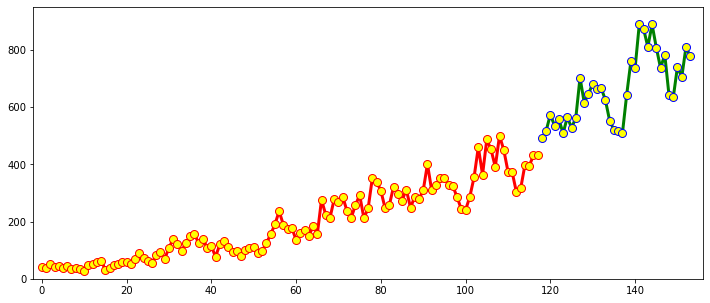

In [19]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(  range(len(S)), S
        , lw=3, c='r', ls='-'
        , marker='o', markersize=8
        , mec='red' , mew=1, mfc='yellow')

ax.plot(  np.arange(len(S),len(S)+N), Preds
        , lw=3, c='g', ls='-'
        , marker='o', markersize=8
        , mec='blue', mew=1, mfc='yellow' )
plt.xlim([-2,len(S)+N+2])
plt.ylim([0,950])

plt.savefig( Project_Name+'_Version_'+version+'_.png', dpi=120 )
plt.show()

##### 